In [1]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import models
from tensorflow.keras import layers

import pandas as pd

2022-12-12 21:32:23.309141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 21:32:24.361421: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2022-12-12 21:32:24.361537: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2022-12-12 21:32:24.371043: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2022-12-12 21:32:27.709175: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 2 compatible adapters.


Na początku załadowano dane za pomocą frameworku Pandas:

In [2]:
cars = pd.read_csv('car.data', encoding='utf-8')
cars

,buying,maint,doors,persons,lug_boot,safety,accept
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


Następnie zamieniono wartości tekstowe na wartości liczbowe:

In [3]:
cars['buying'].replace(['low', 'med', 'high', 'vhigh'], [0,1,2,3], inplace=True)
cars['maint'].replace(['low', 'med', 'high', 'vhigh'], [0,1,2,3], inplace=True)
cars['doors'].replace(['2', '3', '4', '5more'], [0,1,2,3], inplace=True)
cars['persons'].replace(['2', '4', 'more'], [0,1,2], inplace=True)
cars['lug_boot'].replace(['small', 'med', 'big'], [0,1,2], inplace=True)
cars['safety'].replace(['low', 'med', 'high'], [0,1,2], inplace=True)
cars['accept'].replace(['unacc', 'acc', 'good', 'vgood'], [0,1,2,3], inplace=True)

Następnie rozdzielono atrybut klasy decyzyjnej od reszty danych:

In [4]:
from sklearn.model_selection import train_test_split

x = cars.drop("accept", axis=1)
y = cars["accept"]

Kolejnym krokiem było użycie drzewa decyzyjnego w celu sklasyfikowania danych, a także wygenerowanie metryk:
- MAE (Mean Absolute Error - średni błąd bezwzględny) i MSE (Mean Square Error - średni błąd kwadratowy), służących do pomiaru skuteczności regresji,
- True Positive Rate - określającej odsetek poprawnie sklasyfikowanych danych o klasie pozytywnej,
- True Negative Rate - określającej odsetek poprawnie sklasyfikowanych danych o klasie pozytywnej,
- False Positive Rate - określającej odsetek danych o klasie negatywnej błędnie sklasyfikowanych jako dane o klasie pozytywnej,
- False Negative Rate - określającej odsetek danych o klasie pozytywnej błędnie sklasyfikowanych jako dane o klasie negatywnej.

Dodatkowo obliczono średnią i odchylenie standardowe metryk MAE i MSE:

In [5]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, classification_report

k_folds = KFold(n_splits = 5)
DT_classifier = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=42)
predictions = []

mean_absolute_errors = []
mean_square_errors = []
TPRs = []
TNRs = []
FPRs = []
FNRs = []

for i, (train_index, test_index) in enumerate(k_folds.split(x)):
    X_train, X_test = x.iloc[train_index,:], x.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    DT_classifier.fit(X_train, y_train)
    prediction = DT_classifier.predict(X_test)
    cm = confusion_matrix(y_test, prediction)
    predictions.append(prediction)
    print("Confusion matrix for fold #" + str(i + 1))
    print(cm)
    print("Classification report for fold #" + str(i + 1))
    print(classification_report(y_test, prediction))
    # Wyświetlić tutaj metryki MAE, MSE, TP rate, TN rate, FP rate, FN rate, sumować do tablicy i pod koniec wyświetlić
    # średnią i odchylenie standardowe dla tych metryk
    mae = mean_absolute_error(y_test, prediction)
    mean_absolute_errors.append(mae)
    mse = mean_squared_error(y_test, prediction)
    mean_square_errors.append(mse)
    print("Mean absolute error for fold #" + str(i + 1))
    print(mae)
    print("Mean squared error for fold #" + str(i + 1))
    print(mse)
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    print("TP rate for fold #" + str(i + 1) + " (unacc, acc, good, vgood)")
    TPR = TP/(TP+FN)
    TPRs.append(TPR)
    print(TPR)
    print("TN rate for fold #" + str(i + 1) + " (unacc, acc, good, vgood)")
    TNR = TN/(TN+FP) 
    TNRs.append(TNR)
    print(TNR)
    print("FP rate for fold #" + str(i + 1) + " (unacc, acc, good, vgood)")
    FPR = FP/(FP+TN)
    FPRs.append(FPR)
    print(FPR)
    print("FN rate for fold #" + str(i + 1) + " (unacc, acc, good, vgood)")
    FNR = FN/(TP+FN)
    FNRs.append(FNR)
    print(FNR)
    
    print("=======================================")

print("Mean for MAE:")
print(np.mean(np.asarray(mean_absolute_errors)))
print("Stdev for MAE:")
print(np.std(np.asarray(mean_absolute_errors)))
print("Mean for MSE:")
print(np.mean(np.asarray(mean_square_errors)))
print("Stdev for MSE:")
print(np.std(np.asarray(mean_square_errors)))

Confusion matrix for fold #1
[[242  64]
 [  0  40]]
Classification report for fold #1
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       306
           1       0.38      1.00      0.56        40

    accuracy                           0.82       346
   macro avg       0.69      0.90      0.72       346
weighted avg       0.93      0.82      0.85       346

Mean absolute error for fold #1
0.18497109826589594
Mean squared error for fold #1
0.18497109826589594
TP rate for fold #1 (unacc, acc, good, vgood)
[0.79084967 1.        ]
TN rate for fold #1 (unacc, acc, good, vgood)
[1.         0.79084967]
FP rate for fold #1 (unacc, acc, good, vgood)
[0.         0.20915033]
FN rate for fold #1 (unacc, acc, good, vgood)
[0.20915033 0.        ]
Confusion matrix for fold #2
[[263   5]
 [ 44  34]]
Classification report for fold #2
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       268
         

/home/djwilde/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/djwilde/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/djwilde/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_1783/18627

Następnie podzielono dane na dane treningowe i testowe oraz wytrenowano klasyfikator drzewa decyzyjnego na ich podstawie:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [7]:
DT_classifier = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=42)
DT_classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

In [8]:
y_pred = DT_classifier.predict(X_test)

In [9]:
confusion_matrix(y_test, y_pred)

array([[284,  22,   0,   1],
       [ 10,  82,   0,   3],
       [  0,   6,   0,   5],
       [  0,   4,   0,  15]])

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       307
           1       0.72      0.86      0.78        95
           2       0.00      0.00      0.00        11
           3       0.62      0.79      0.70        19

    accuracy                           0.88       432
   macro avg       0.58      0.64      0.61       432
weighted avg       0.87      0.88      0.87       432



/home/djwilde/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/djwilde/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/djwilde/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Na koniec wygenerowano graf drzewa decyzyjnego za pomocą biblioteki graphviz:

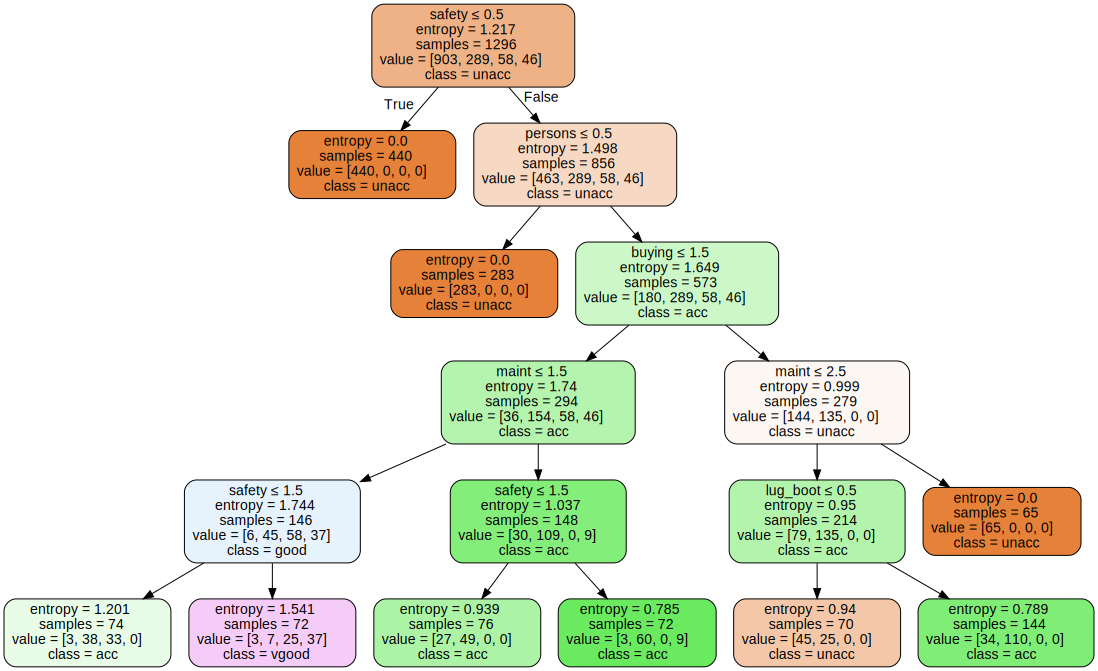

In [11]:
# Plot the tree.
from sklearn import tree
import graphviz 
from graphviz import Source
dot_data = tree.export_graphviz(DT_classifier, out_file=None, feature_names=x.columns,class_names=['unacc', 'acc', 'good', 'vgood'], filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 